<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/iCarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jun  2 08:34:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    65W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_ 
from torch.nn.init import kaiming_uniform_
import numpy as np

### DATA LOADER RANDOM


In [3]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128

trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)

for i in range(len(trainset_raw)):
  if(i==0):
    trainset = [[trainset_raw[i][0], trainset_raw[i][1]]]
  else:
    trainset.append([trainset_raw[i][0], trainset_raw[i][1]])


# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### NETWORK


In [4]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def addOutputNodes(self, num_new_outputs):
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features + num_new_outputs)

        #xavier initialization
        # xavier_uniform_(self.fc.weight)

        #kaiming initialization
        # kaiming_uniform_(self.fc.weight)
        self.fc.weight.data[:out_features] = weight
        


def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

In [5]:
net = resnet32()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

### LOSS and PARAMETERS

In [6]:
lr = 0.01
decay = 0.0001
epochs = 40
momentum = 0.9
factor = 5

In [7]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### ICARL

In [8]:
import sys

def constructExemplarSet(Xclass, m):
#Xclass contiene immagini e label della classe X
  exemplars_set = []
  feature_exemplars = []
  indexes = []
  features = [] 

  with torch.no_grad():
    XtrainLoader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=1, num_workers=2)
    for i, data in enumerate(XtrainLoader, 0):
      image = data[0].to(device)
      # per ogni immagine della classe x, prendiamo le rispettive feature e le uniamo nel vettore features, che contiene tutte quelle delle immagini della classe x
      feature = net.forward(image)
      #print(feature)
      feature.data = feature.data/feature.data.norm()
      features.append(feature)

    features = torch.cat(features, dim=0) #cat solve the problem of inequal size of tensors 
    current_class_mean = features.mean(0) # mu = media delle features delle immagini della classe

    for k in range(1, m+1):
      min = 100000
      sum = 0
      for j in range(k-1):
        sum += feature_exemplars[j]
      for x in range(len(Xclass)): 
        if (x not in indexes):
          phiX = features[x]
          val = current_class_mean - ((phiX + sum)/k)
          val = np.linalg.norm(val.cpu().numpy()) ## NORMA 
          #res = torch.lt(val, min)
        #res.sum() ritorna il numero di True 
          #sumTrue = res.sum() #sumTrue restituisce il numero di True all'interno del tensore Res 
          #lenghtTmp = res.shape # dimensione del tensore
          #lenght = list(lenghtTmp)[0]
          #res = (lenght == sumTrue)
          #trueLabel = torch.tensor(True).to(device)
          #if (torch.equal(trueLabel, res)):
          if (val < min):
            min = val
            feature_min = phiX
            index_min = x
      indexes.append(index_min)
      feature_exemplars.append(feature_min)
      exemplars_set.append(Xclass[index_min])

    print("lunghezza exemplar set: ", len(exemplars_set))
    return exemplars_set


In [9]:
# DA CHIAMARE PER OGNI CLASSE k: riduce il numero di exemplars all'interno dell'exemplar_set della classe k 
def reduceExemplarSet(m, exemplars_set):
  exemplars_new = []
  for i in range(m):
    exemplars_new.append(exemplars_set[i])

  return exemplars_new

In [10]:
def updateRepresentation(train_iter, exemplars_set_tot, network, iteration, device, epochs, num_classes):
  #exemplars_set_tot contiene tutti gli exemplars set ottenuti fino ad ora
  #train_iter contiene tutti i dati (immagini + labels) delle classi nuove (s, .., t)
  
  for k, v in exemplars_set_tot.items():
    print(k)
    train_iter += v 
  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  # train_loader è la concatenazione delle nuove classi con gli exemplar_sets calcolati fino a questo punto 
  print("training")
  training(train_loader, iteration, network, device, epochs, num_classes)

In [11]:
def incrementalTrain(train_iter, iteration, network, device, epochs, num_classes, K, exemplars_set_tot):
  print("Starting the update reprensentation")
  updateRepresentation(train_iter, exemplars_set_tot, network, iteration, device, epochs, num_classes)
  
  t = (num_classes * iteration) + num_classes # num_classes ricevute fino a questo momento 
  m = int(K/t) #casto ad intero ? per difetto o eccesso?
  s = num_classes * iteration

  print("reducing examplar for each class")
  for y in range(1, s):
    exemplar_y_new = reduceExemplarSet(m, exemplars_set_tot[y]) # valore associato alla chiave y che rappresenta il label della classe 
    exemplars_set_tot[y] = exemplar_y_new
  
  for y in range(s, t):
    class_y = []
    for i in range(len(train_iter)):
      if(train_iter[i][1]==y):
        class_y.append(train_iter[i])
    print("Constructing examplars of class", y)
    exemplars_set = constructExemplarSet(class_y, m)
    exemplars_set_tot[y] = exemplars_set

In [12]:
def training(trainloader, iteration, network, device, epochs, num_classes):
  distillation_loss = 0
  old_net = copy.deepcopy(network)
  n = num_classes * (iteration + 1)
  m = num_classes
  lambdaL = 0
  if (iteration != 0):
    # add 10 output nodes to the network
    network.addOutputNodes(num_classes)
    network.to(device)
  
  optimizer = optim.SGD(network.parameters(), lr = lr, weight_decay=decay,momentum= momentum)
  #train the network
  for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      inputs = data[0].to(device)
      labels = data[1].to(device)
      
      # Sets the gradients of all optimized torch.Tensor to zero.
      optimizer.zero_grad() 

      # forward: assign weights to each edge in each layer
      outputs = network.forward(inputs) 

       # calculate the classification loss 
      classification_loss = criterion(outputs,labels) 

      #if (iteration > 0):
      # calculate the distillation loss
       # distillation_loss = dist_loss(outputs, old_net, inputs) 
       # lambdaL = n/(n+m)
      
      loss = classification_loss #+ lambdaL*distillation_loss

      # redesign the weights evaluating the performance of the network
      loss.backward() 

      # update parameters
      optimizer.step()  

      running_loss += loss.item()

      # print every 20 mini-batches the average value of the loss accumulated in each batch
      if i % 200 == 199:    
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0

In [13]:
def dist_loss(outputs, old_net, inputs):
    out_old = torch.sigmoid(old_net.forward(inputs))
    out_old_new = torch.argmax(out_old, dim=1)
    distillation_loss = criterion(outputs, out_old_new)
    return distillation_loss

In [14]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(testloader, iteration, network):
  confusion_matrix = torch.zeros(iteration*10+10,iteration*10+10)
  print("confusion matrix shape: ", confusion_matrix.shape)
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(),p.long()] += 1

  plt.figure()
  plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.plasma)
  plt.show()
  #acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

###MAIN

Train the network, iteration:  0  on classes:  range(0, 10)
Starting the update reprensentation
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
training
reducing examplar for each class
Constructing examplars of class 0
lunghezza exemplar set:  200
Constructing examplars of class 1
lunghezza exemplar set:  200
Constructing examplars of class 2
lunghezza exemplar set:  200
Constructing examplars of class 3
lunghezza exemplar set:  200
Constructing examplars of class 4
lunghezza exemplar set:  200
Constructing examplars of class 5
lunghezza exemplar set:  200
Constructing examplars of class 6
lunghezza exemplar set:  200
Constructing examplars of class 7
lunghezza exemplar set:  200
Constructing examplars of class 8
lunghezza exemplar set:  200
Const

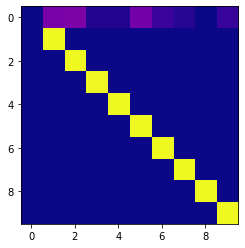

Accuracy of the network on the 0 iteration: 89 %
Train the network, iteration:  1  on classes:  range(10, 20)
Starting the update reprensentation
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
training
reducing examplar for each class
Constructing examplars of class 10
lunghezza exemplar set:  100
Constructing examplars of class 11
lunghezza exemplar set:  100
Constructing examplars of class 12
lunghezza exemplar set:  100
Constructing examplars of class 13
lunghezza exemplar set:  100
Constructing examplars of class 14
lunghezza exemplar set:  100
Constructing examplars of class 15
lunghezza exemplar set:  100
Constructing examplars of class 16
lunghezza exemplar set:  100
Constructing examplars of class 17
lunghezza exemplar set:  100
Constructi

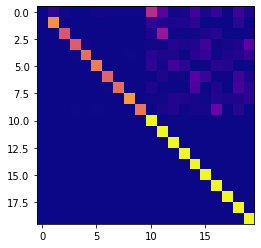

Accuracy of the network on the 1 iteration: 79 %
Train the network, iteration:  2  on classes:  range(20, 30)
Starting the update reprensentation
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
training
reducing examplar for each class
Constructing examplars of class 20
lunghezza exemplar set:  66
Constructing examplars of class 21
lunghezza exemplar set:  66
Constructing examplars of class 22
lunghezza exemplar set:  66
Constructing examplars of class 23
lunghezza exemplar set:  66
Constructing examplars of class 24
lunghezza exemplar set:  66
Constructing examplars of class 25
lunghezza exemplar set:  66
Constructing examplars of class 26
lunghezza exemplar set:  66
Constructing examplars of class 27
lunghezza exemplar set:  66
Constructing examp

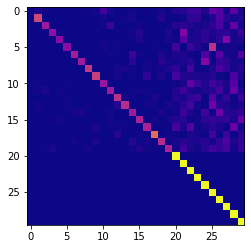

Accuracy of the network on the 2 iteration: 57 %
Train the network, iteration:  3  on classes:  range(30, 40)
Starting the update reprensentation
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
training
reducing examplar for each class
Constructing examplars of class 30
lunghezza exemplar set:  50
Constructing examplars of class 31
lunghezza exemplar set:  50
Constructing examplars of class 32
lunghezza exemplar set:  50
Constructing examplars of class 33
lunghezza exemplar set:  50
Constructing examplars of class 34
lunghezza exemplar set:  50
Constructing examplars of class 35
lunghezza exemplar set:  50
Constructing examplars of class 36
lunghezza exemplar set:  50
Constructing examplars of class 37
lunghezza exemplar set:  50
Constructing examp

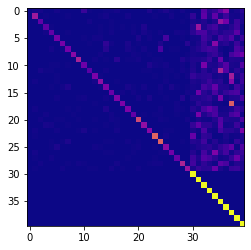

Accuracy of the network on the 3 iteration: 45 %
Train the network, iteration:  4  on classes:  range(40, 50)
Starting the update reprensentation
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
training
reducing examplar for each class
Constructing examplars of class 40
lunghezza exemplar set:  40
Constructing examplars of class 41
lunghezza exemplar set:  40
Constructing examplars of class 42
lunghezza exemplar set:  40
Constructing examplars of class 43
lunghezza exemplar set:  40
Constructing examplars of class 44
lunghezza exemplar set:  40
Constructing examplars of class 45
lunghezza exemplar set:  40
Constructing examplars of class 46
lunghezza exemplar set:  40
Constructing examplars of class 47
lunghezza exemplar set:  40
Constructing examp

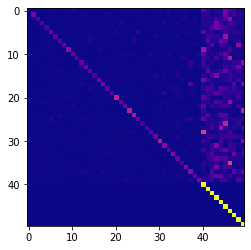

Accuracy of the network on the 4 iteration: 36 %
Train the network, iteration:  5  on classes:  range(50, 60)
Starting the update reprensentation
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
training


In [ ]:
# MAIN
K = 2000
iterations = 10
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
exemplars_set_tot = {new_list: [] for new_list in range(100)}
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = []
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])
  
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
  incrementalTrain(train_iter, i, net, device, epochs, num_classes, K, exemplars_set_tot) # Train the network with 10 classes at a time
  test(valid_loader, i, net) # Test the network with all classes seen until this iteration